# Preprocessing Total Revenue

## TODO:
* Train test split 
* Statistics. Distribution of length of series.

## Settings

In [4]:
num_entries_req = 16
df_all = pd.DataFrame()
describe_dicts = []
#df_describe.index = ["count", "min", "max", "mean", "std", "longest", "shortest"]

In [3]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [5]:
sector_data = {path[path.find("____")+len("____"):-len(".parquet")]:path for path in glob.glob("data/fundamental_data/total_revenue/*")}
sector_data.keys()

dict_keys(['business_services', 'consumer_cyclicals', 'consumer_non-cyclicals', 'consumer_services', 'energy', 'finance', 'healthcare', 'industrials', 'non-corporate', 'non-energy_materials', 'other', 'technology', 'telecommunications', 'utilities'])

## Statistics for each sector before processing

In [7]:
tot_comp = 0
all_comp_sect_dict = {}

for s in sector_data.keys():
    df = pd.read_parquet(sector_data[s], engine='pyarrow')
    tot_comp += len(df.columns)
    for comp in df.columns:
        if comp not in all_comp_sect_dict.keys():
            all_comp_sect_dict[comp] = [s]
        else:
            all_comp_sect_dict[comp].append(s)

tot_comp

32370

In [11]:
for key in all_comp_sect_dict.keys():
    if len(all_comp_sect_dict[key]) > 4:
        print(f"{key:30} : {all_comp_sect_dict[key]}")

CIR SpA - CIE Industriali Riunite SpA : ['business_services', 'consumer_cyclicals', 'consumer_services', 'healthcare', 'industrials']
Ildong Holdings Co., Ltd.      : ['business_services', 'consumer_cyclicals', 'finance', 'healthcare', 'technology']


In [15]:
df_bus = pd.read_parquet(sector_data["business_services"], engine='pyarrow')
df_cons = pd.read_parquet(sector_data["consumer_cyclicals"], engine='pyarrow')

bus = df_bus["Ildong Holdings Co., Ltd."]
cons = df_cons["Ildong Holdings Co., Ltd."]
bus.values, cons.values

(array([    nan,     nan,     nan,     nan,     nan,  62091.,     nan,
            nan,  67675.,     nan,     nan,  64211.,     nan,     nan,
            nan,     nan,     nan,  68653.,     nan,     nan,  75650.,
            nan,     nan,  71903.,     nan,     nan,     nan,     nan,
            nan,  70324.,     nan,     nan,  79190.,     nan,     nan,
         81167.,     nan,     nan,     nan,     nan,     nan,  76052.,
            nan,     nan,  84841.,     nan,     nan,     nan,     nan,
            nan,  80718.,     nan,     nan,  84191.,     nan,     nan,
         85284.,     nan,     nan,     nan,     nan,     nan,  74493.,
            nan,     nan,  96112.,     nan,     nan,  89526.,     nan,
            nan, 100131.,     nan,     nan,  85731.,     nan,     nan,
         92018.,     nan,     nan, 109022.,     nan,     nan, 108459.,
            nan,     nan,  90234.,     nan,     nan, 103724.,     nan,
            nan, 108092.,     nan,     nan, 115465.,     nan,     nan,
      

In [171]:
df_orig = pd.read_parquet(sector_data["non-corporate"], engine='pyarrow')
df = df_orig.copy()
num_companies_sector = df.shape[1]
num_months_sector = df.shape[0]
companies_sector = df.columns

In [186]:
df_orig.head()

""


We check when companies do their reporting and find that most do it in March, June, October and December. The reported total revenue from the quarterly report is logged back to the end of the fiscal period the company use. On the basis of the plot we drop all companies which don't report in these months. Also we assume they report at the same time. This is not true, but saves us for a lot of trouble and is not a big issue.  

In [172]:
df_stats = df.copy()
df_stats ["reported"] = len(df_stats.columns)-df_stats.isnull().sum(axis=1)
df_stats["month"] = df_stats.index.month
df_months = pd.concat((df_stats["month"], df_stats["reported"]), axis=1).groupby("month").sum()
df_months


,reported
month,


## Removing all companies with non standard fiscal periods
The number of companies are growing. A way to remove the wrong fiscal period companies is by looking at 2019 and remove any company that did not report in e.g. June. We remove all companies that have ever reported in another month than March, June, September or December.

In [173]:
drop_set = set()
drop_months = [1,2,4,5,7,8,10,11]
for m in drop_months:
    fail_cols = df_stats.columns[np.where(df_stats[df_stats["month"] == m].notna().apply(np.sum, axis=0) > 0)[0].tolist()].tolist()
    drop_set.update(fail_cols)
df_stats = df_stats.drop(columns=list(drop_set))
drop_set.remove("month")
drop_set.remove("reported")
df = df.drop(columns=list(drop_set))
print("Dropping ", len(drop_set), " columns that have non standard fiscal period. This is ",  round(len(drop_set) / num_companies_sector , 4)* 100, "% of the companies. We still have ", round(len(df.columns) / num_companies_sector,4) * 100, " of the original companies.")




KeyError: 'month'

In [174]:
df["reported"] = len(df.columns)-df.isnull().sum(axis=1)
df["month"] = df.index.month
df_months = pd.concat((df["month"], df["reported"]), axis=1).groupby("month").sum()
df_months

,reported
month,


## Fuck yeah
Lets remove all months except March, June, September and December.

In [175]:
df = df[(df["month"] == 3) | (df["month"] == 6) | (df["month"] == 9) | (df["month"] == 12)]

We have to treat any case where we have NaNs in between reported numbers or where the company stopped reporting. Or should the last ones discussed be kept?? They might give insight into if a company is about to shut down.

Anyhow We do this by treating each column, shifting it and apply to check if there is a NaN in the right column (shifted) and not one in the left. This goes into a new column and we check if there is a False there. If so count. We need to count to see if we can drop them or not.

All are allowed one from the roll function and one from ending. If there are more than two there is a problem!!

vv Example of a company that has missing entries. The missing entries are at the end of the fiscal year so they might be in the yearly report or something.

In [176]:
#df_orig["THELMA Therapeutics Co., Ltd."].head()

In [177]:
def f(a, b):
    if a and not b:
        return True
    else:
        return False

In [178]:
tot = 0
drop_cols = []
for col in df.columns:
    df_test = pd.DataFrame([np.roll(df[col], 1), df[col].to_numpy()]).T
    df_test.columns = ["rolled", "original"]
    df_test = df_test.isna()
    df_test["susp"] = df_test.apply(lambda r: f(r["rolled"], r["original"]) , axis=1)
    count_df = df_test["susp"].value_counts()
    try:
        if count_df[True] > 2:
            tot += 1
            drop_cols.append(col)
    except:
        pass
df = df.drop(columns=drop_cols)
print(f"Dropping {tot} columns because of missing reported earnings. The dataset contains {round(len(df.columns) / len(df_orig.columns),4) * 100} % of the original companies.")


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

We have to disregarde some series if they are too short. Our model pads series that are too short, but we should require some length at least. Let's require 4 years -> 16 quarters as there seems to be a split in the data there.  

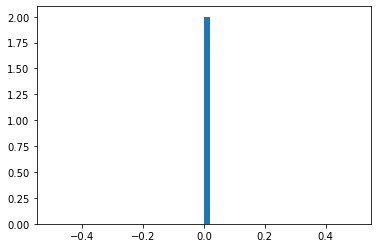

In [179]:
df.count().hist(bins=50, grid=False)
plt.show()

In [180]:
drop_cols = df.count().where(df.count()<num_entries_req).dropna(axis=0).index.tolist()
df = df.drop(columns=drop_cols)
print(f"Dropping {len(drop_cols)} columns because of missing reported earnings. The dataset contains {round(len(df.columns) / len(df_orig.columns), 4)* 100}% of the original companies.")

ZeroDivisionError: division by zero

In [181]:
(1-df.isna()).sum(axis=1).plot()
plt.title("Number of companies reporting")
plt.show()

TypeError: no numeric data to plot

## Statistics

In [182]:
d = {}

In [183]:
vals = df.values.flatten()
vals = vals[np.logical_not(np.isnan(vals))]

In [184]:
d["count"] = len(df.columns)
d["min"] = np.min(vals)
d["max"] = np.max(vals)
d["mean"] = np.mean(vals)
d["std"] = np.std(vals)
d["longest"] = max(df.count())
d["shortest"] = min(df.count())
describe_dicts.append(d)

ValueError: zero-size array to reduction operation minimum which has no identity

In [185]:
d

{'count': 0}

### TODO:
* Make a TS that only has March, June, Sept and Dec.
* Set NaN to 0?
* Combine all datasets. What is a good way to do this? Should also have somewhere to store the sector metadata. Dict?